# Fine-Tuning Pretrained CNNs for SARS-CoV-3 Diagnostic Image Classification
**Author: Paul Roode**

**_NOTE: The computation time of this Jupyter Notebook is ~40 min on a Google Colab GPU accelerator. Most of this time is allocated to retuning the weights of pretrained InceptionV3 and ResNet50 models after replacing their final layers with ones suitable for classifying chest X-ray images._**

## Objectives

1. Rearchitect then retune pretrained Convolutional Neural Networks (CNNs) to develop an ML model capable of optimally distinguishing patients infected with SARS-CoV-3 from patients that have pneumonia or are uninfected.

2. Evaluate the performance of the repurposed CNNs using different metrics, i.e., learning curves, confusion matrices, precision-recall curves, etc.

3. Compute the size of the best model for storage considerations.

## About the Dataset
The dataset is provided by The Ottawa Hospital and available for download [here](https://github.com/jrgreen7/SYSC4906/releases/download/Assignment2/SYSC4415W23_A2_dataset.zip). It contains `training`, `validation`, and `test` folders each containing `normal`, `pneumonia`, and `sarscov3` subfolders containing 200$\times$200-px chest X-ray images with random filenames, as well as a CSV file comprising metadata for each image.

Get the dataset:

In [ ]:
!rm -rf SYSC4415W23_A2_dataset SYSC4415W23_A2_dataset.zip
!wget https://github.com/jrgreen7/SYSC4906/releases/download/Assignment2/SYSC4415W23_A2_dataset.zip && unzip SYSC4415W23_A2_dataset.zip

Install dependencies:

In [ ]:
!pip install git+https://github.com/nottombrown/imagenet_stubs
!pip install timm
!pip install torchstat

## Data Inspection and Preparation

Import libraries:

In [ ]:
from matplotlib.pyplot import bar, show, title, xlabel, ylabel
from pandas import read_csv

Load a DataFrame comprising the image metadata:

In [ ]:
imageMetadataFrame = read_csv('SYSC4415W23_A2_dataset/dataset_metadata.csv')

Get the sample size of each set:

In [ ]:
trainingCount = len(imageMetadataFrame.query('split == "training"'))
validationCount = len(imageMetadataFrame.query('split == "validation"'))
testCount = len(imageMetadataFrame.query('split == "test"'))

print(f'Number of images in training set: {trainingCount}')
print(f'Number of images in validation set: {validationCount}')
print(f'Number of images in test set: {testCount}')

Number of images in training set: 2222
Number of images in validation set: 645
Number of images in test set: 505


Get the class composition of the dataset:

In [ ]:
labelCounts = imageMetadataFrame['label'].value_counts()
print(f'Label counts:\n{labelCounts}')

Label counts:
normal       1500
pneumonia    1300
sarscov3      572
Name: label, dtype: int64


Prepare a bar chart from the label counts to visualize class imbalance:

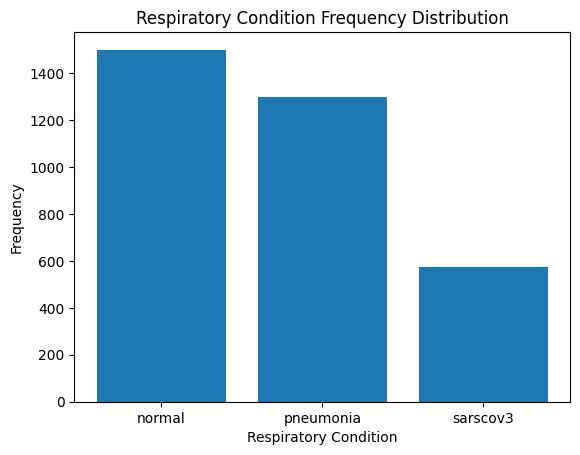

In [ ]:
bar(labelCounts.index, labelCounts.values)
xlabel('Respiratory Condition')
ylabel('Frequency')
title('Respiratory Condition Frequency Distribution')
show()

📝 The data is slightly imbalanced: there are fewer SARS-CoV-3 X-rays$-$nearly a 1:3 ratio to the most prevalent class, X-rays of healthy patients. Class imbalance often makes classification more difficult (in particular, when it is present in very high ratios, e.g., 1:100, 1:1000, 1:10000) because the model will naturally focus on correctly classifying majority class samples as it brings the largest reward in terms of loss at the expense of misclassifying samples from the rare class.

The class imbalance can be addressed using different techniques:
- **Sampling techniques:** One can undersample the majority class to decrease the imbalance at the expense of wasting potentially expensive labeled training data. One could also oversample the minority class, e.g., by duplicating samples from the rare class in the training set.
- **Synthetic oversampling:** SMOTE and ADASYN are two examples of synthetic oversampling techniques where new synthetic samples are created by interpolating new samples in the feature space between existing samples from the minority class and assigning those new samples the label of the rare class.
- **Data augmentation:** New synthetic images can be created to artificially augment the prevalence of the rare class by applying operations like occlusion, reflexion, rotation, etc.
- **Cost-sensitive learning:** One can account for the class imbalance in the loss function directly by assigning more weight to certain types of errors (rare class misclassification) than others (prevalent class misclassification).

## Applying Pretrained CNN Models to the Data

Import libraries:

In [ ]:
from imagenet_stubs.imagenet_2012_labels import label_to_name
from matplotlib.pyplot import imread, imshow
from timm import create_model
from torch import softmax
from torchvision.io import read_image

Get an image from the test set:

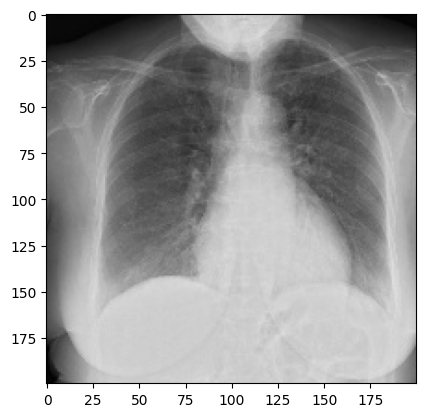

In [ ]:
imagePath = 'SYSC4415W23_A2_dataset/training/sarscov3/100_sarscov3.jpg'
image = imread(imagePath)
imshow(image)

Load the test image in a tensor, call `unsqueeze()` on the tensor to add a dimension, and convert the tensor's entries to floats:

In [ ]:
image = read_image(imagePath).unsqueeze(0).float()

Load ImageNet-pretrained InceptionV3 (`inception_v3`) and ResNet50 (`resnet50`) models using PyTorch Image Models (`timm`), then use the models to predict the class of the test image along with the probability. The probability is the result of applying the softmax function to the logits.

In [ ]:
# Abstract prediction logic into a function for DRY
def predictClass(modelName, image):
    ''' Predicts the class and probability of a given image using a given model.
    '''
    # Load the specified model and set it to evaluation mode
    model = create_model(modelName, pretrained=True)
    model.eval()

    # Get the predicted class and probability for the image
    logits = model(image)
    probabilities = softmax(logits, dim=1)
    predictedClass = probabilities.argmax().item() # Find the index of the class with the highest probability
    predictedClassName = label_to_name(predictedClass)

    # Print the results
    print(f'{modelName} predicted class: {predictedClassName}')
    print(f'{modelName} predicted probability: {probabilities[0, predictedClass].item()}\n')

# Use the function to predict with InceptionV3
predictClass('inception_v3', image)

# Use the function to predict with ResNet50
predictClass('resnet50', image)

inception_v3 predicted class: pitcher, ewer
inception_v3 predicted probability: 0.9999599456787109

resnet50 predicted class: kelpie
resnet50 predicted probability: 1.0



📝 Of course, because the models were pretrained on ImageNet, they do not (yet) predict any of the classes of interest$-$it is expected that the predictions will be incorrect if the models are deployed without additional modifications and training. Both models are very confident in their predictions, which is generally a good thing as it indicates that the models perform well on the task, although overly confident predictions can indicate a lack of generalization ability; however, in this case, the high confidence is not a good thing because the models are incorrect (as they have not yet been repurposed) and we want incorrect predictions to be associated with low confidence.

## Instantiating DataLoaders for Fine-Tuning
When working with large image datasets with PyTorch, DataLoaders are often implemented to help manage how images are loaded during training. A DataLoader can be combined with data augmentation, i.e., image transforms such as occlusion, reflexion, rotation, etc.

Import libraries:

In [ ]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder

Use the `ImageFolder` strategy to build a DataLoader with a batch size of 128 for training. Apply the following data augmentation transforms:
1. Random rotation between -10 and 10 deg
2. Random horizontal flip with 40% probability

In [ ]:
batchSize = 128

# Define data augmentation transforms for the training set
trainTransforms = transforms.Compose([
    transforms.RandomRotation(degrees=(-10, 10)),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.ToTensor()
])

# Create the training DataLoader
trainDataset = ImageFolder('SYSC4415W23_A2_dataset/training', transform=trainTransforms)
trainDataLoader = DataLoader(trainDataset, batch_size=batchSize, shuffle=True)

Create the DataLoaders that will be used for validation and testing:

In [ ]:
# Define data augmentation transforms for the validation set
valTransforms = transforms.Compose([
    transforms.ToTensor()
])

# Create the validation DataLoader
valDataset = ImageFolder('SYSC4415W23_A2_dataset/validation', transform=valTransforms)
valDataLoader = DataLoader(valDataset, batch_size=batchSize)

In [ ]:
# Define data augmentation transforms for the test set
testTransforms = transforms.Compose([
    transforms.ToTensor()
])

# Create the test DataLoader
testDataset = ImageFolder('SYSC4415W23_A2_dataset/test', transform=testTransforms)
testDataLoader = DataLoader(testDataset) 

## Modifying and Fine-Tuning Existing CNN Architectures

In order to leverage the previously-loaded InceptionV3 and ResNet50 models for our purposes, their final classification layers must be replaced with ones comprising an appropriate number of classes, and then their weights must be retuned so that the models become suitable for classifying the X-rays.

Import libraries:

In [ ]:
import time
from matplotlib.pyplot import subplots
from timm import create_model
from torch import cuda, no_grad, save, Tensor
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW

**Step 1:** Load the InceptionV3 and ResNet50 models and replace their final classification layers with new, dense layers comprising an appropriate number of classes:

In [ ]:
# Define the number of output classes
numClasses = 3

# Load the InceptionV3 and ResNet50 models and replace their final classification layers
inceptionV3Model = create_model('inception_v3', pretrained=True, num_classes=numClasses)
resNet50Model = create_model('resnet50', pretrained=True, num_classes=numClasses)

**Step 2:** Train the final layer-modified InceptionV3 and ResNet50 models using the following settings:
- **Base learning rate:** $5(10^{-4})$ $-$ will be converted to an effective learning rate based on the batch size using the heuristic 
$\eta_{\mathrm{eff}} = \frac{B\eta_{\mathrm{base}}}{256}$, 
where $\eta$ is the learning rate and $B$ is the batch size
- **Epochs:** 25
- **Optimizer:** AdamW
- **Loss function:** Cross-entropy (not required here, but note that using the weight parameter could help deal with class imbalance)

In [ ]:
# Move the modified InceptionV3 model to GPU
device = 'cuda' if cuda.is_available() else 'cpu'
inceptionV3Model.to(device)

In [ ]:
# Instantiate the optimizer for the modified InceptionV3 model using the specified effective learning rate
baseLR = 0.0005
effectiveLR = batchSize * baseLR / 256
optimizer = AdamW(inceptionV3Model.parameters(), lr=effectiveLR)

In [ ]:
# Set up the loss function for the modified InceptionV3 model
lossFunction = CrossEntropyLoss()

In [ ]:
# Fine-tune the weights in the final layer of the modified InceptionV3 model
numEpochs = 25
inceptionV3TrainLosses = [] 
inceptionV3ValLosses = []
for epoch in range(numEpochs):
    startTime = time.time()
    inceptionV3Model.train()
    trainLosses = []
    for batch in trainDataLoader:
        batchImages, batchLabels = batch
        batchImages, batchLabels = batchImages.to(device), batchLabels.to(device)

        logits = inceptionV3Model(batchImages) # Passes the batch of images through the model and obtains the class logits (i.e., forward pass)
        loss = lossFunction(logits, batchLabels) # Computes the CE loss between logits and labels (internally does a softmax)
        loss.backward() # Computes the gradients of every parameter (i.e., backward pass)

        optimizer.step() # Updates parameters based on the gradients (and their momentums in this case) and learning rate
        optimizer.zero_grad() # Resets gradients
        trainLosses.append(loss.item())
  
    inceptionV3Model.eval()
    valLosses = []
    with no_grad(): # Don't need gradients in eval mode (saves memory and time during inference)
        for batch in valDataLoader:
            batchImages, batchLabels = batch
            batchImages, batchLabels = batchImages.to(device), batchLabels.to(device)

            logits = inceptionV3Model(batchImages)
            loss = lossFunction(logits, batchLabels)
            valLosses.append(loss.item())

    trainTime = time.time() - startTime
    epochTrainLoss = Tensor(trainLosses).mean().item()
    epochValLoss = Tensor(valLosses).mean().item()
    inceptionV3TrainLosses.append(epochTrainLoss) # For learning curve visualization
    inceptionV3ValLosses.append(epochValLoss) # For learning curve visualization
    print(f'Epoch: {epoch}  Train loss: {epochTrainLoss:8.6f}  Val loss: {epochValLoss:8.6f}  Time: {trainTime:6.4f}')

Epoch: 0  Train loss: 0.515617  Val loss: 0.472405  Time: 24.3796
Epoch: 1  Train loss: 0.184250  Val loss: 0.124274  Time: 20.8934
Epoch: 2  Train loss: 0.107652  Val loss: 0.088724  Time: 19.4681
Epoch: 3  Train loss: 0.060625  Val loss: 0.078990  Time: 20.2354
Epoch: 4  Train loss: 0.050544  Val loss: 0.077588  Time: 20.1440
Epoch: 5  Train loss: 0.048198  Val loss: 0.075293  Time: 18.9373
Epoch: 6  Train loss: 0.033410  Val loss: 0.055870  Time: 18.9351
Epoch: 7  Train loss: 0.029572  Val loss: 0.070436  Time: 18.6367
Epoch: 8  Train loss: 0.045460  Val loss: 0.116194  Time: 18.8767
Epoch: 9  Train loss: 0.076502  Val loss: 0.073940  Time: 18.9059
Epoch: 10  Train loss: 0.058913  Val loss: 0.105938  Time: 18.9269
Epoch: 11  Train loss: 0.018468  Val loss: 0.140201  Time: 18.6991
Epoch: 12  Train loss: 0.027515  Val loss: 0.110833  Time: 18.9365
Epoch: 13  Train loss: 0.015614  Val loss: 0.097473  Time: 19.8088
Epoch: 14  Train loss: 0.010478  Val loss: 0.098778  Time: 20.8951
Epoch

In [ ]:
# Move the modified ResNet50 model to GPU
resNet50Model.to(device)

In [ ]:
# Instantiate the optimizer for the modified ResNet50 model
optimizer = AdamW(resNet50Model.parameters(), lr=effectiveLR)

In [ ]:
# Set up the loss function for the modified ResNet50 model
lossFunction = CrossEntropyLoss()

In [ ]:
# Fine-tune the weights in the final layer of the modified ResNet50 model
numEpochs = 25
resNet50TrainLosses = []
resNet50ValLosses = []
for epoch in range(numEpochs):
    startTime = time.time()
    resNet50Model.train()
    trainLosses = []
    for batch in trainDataLoader:
        batchImages, batchLabels = batch
        batchImages, batchLabels = batchImages.to(device), batchLabels.to(device)

        logits = resNet50Model(batchImages) # Passes the batch of images through the model and obtains the class logits (i.e., forward pass)
        loss = lossFunction(logits, batchLabels) # Computes the CE loss between logits and labels (internally does a softmax)
        loss.backward() # Computes the gradients of every parameter (i.e., backward pass)

        optimizer.step() # Updates parameters based on the gradients (and their momentums in this case) and learning rate
        optimizer.zero_grad() # Resets gradients
        trainLosses.append(loss.item())
  
    resNet50Model.eval()
    valLosses = []
    with no_grad(): # Don't need gradients in eval mode (saves memory and time during inference)
        for batch in valDataLoader:
            batchImages, batchLabels = batch
            batchImages, batchLabels = batchImages.to(device), batchLabels.to(device)

            logits = resNet50Model(batchImages)
            loss = lossFunction(logits, batchLabels)
            valLosses.append(loss.item())

    trainTime = time.time() - startTime
    epochTrainLoss = Tensor(trainLosses).mean().item()
    epochValLoss = Tensor(valLosses).mean().item()
    resNet50TrainLosses.append(epochTrainLoss) # For learning curve visualization
    resNet50ValLosses.append(epochValLoss) # For learning curve visualization
    print(f'Epoch: {epoch}  Train loss: {epochTrainLoss:8.6f}  Val loss: {epochValLoss:8.6f}  Time: {trainTime:6.4f}')

Epoch: 0  Train loss: 0.971711  Val loss: 1.048326  Time: 28.3675
Epoch: 1  Train loss: 0.611179  Val loss: 0.718231  Time: 27.5146
Epoch: 2  Train loss: 0.376123  Val loss: 0.835137  Time: 27.4038
Epoch: 3  Train loss: 0.256991  Val loss: 0.351485  Time: 27.5220
Epoch: 4  Train loss: 0.156680  Val loss: 0.964921  Time: 28.8940
Epoch: 5  Train loss: 0.118222  Val loss: 0.191584  Time: 28.5351
Epoch: 6  Train loss: 0.091342  Val loss: 0.091564  Time: 27.6083
Epoch: 7  Train loss: 0.060087  Val loss: 0.111954  Time: 27.6176
Epoch: 8  Train loss: 0.055274  Val loss: 0.097865  Time: 27.9522
Epoch: 9  Train loss: 0.044672  Val loss: 0.152854  Time: 27.5187
Epoch: 10  Train loss: 0.044817  Val loss: 0.161226  Time: 27.5222
Epoch: 11  Train loss: 0.039458  Val loss: 0.148221  Time: 27.5362
Epoch: 12  Train loss: 0.039495  Val loss: 0.157044  Time: 27.8570
Epoch: 13  Train loss: 0.027891  Val loss: 0.145603  Time: 27.4189
Epoch: 14  Train loss: 0.020056  Val loss: 1.370087  Time: 27.4592
Epoch

**Step 3:** Display the learning curves (loss) for each optimized model:

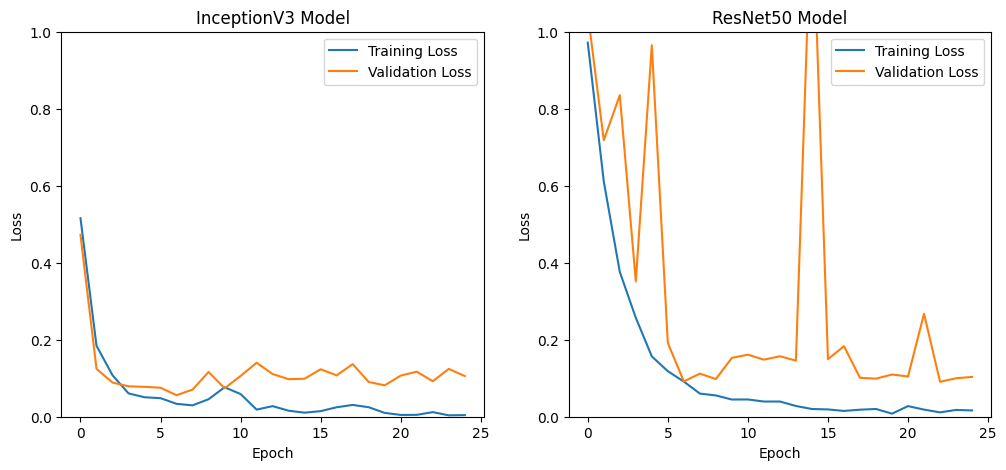

In [ ]:
fig, axs = subplots(1, 2, figsize=(12, 5))

# Plot the learning curves for the InceptionV3 model
axs[0].plot(inceptionV3TrainLosses, label='Training Loss')
axs[0].plot(inceptionV3ValLosses, label='Validation Loss')
axs[0].set_title('InceptionV3 Model')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].set_ylim([0, 1])

# Plot the learning curves for the ResNet50 model
axs[1].plot(resNet50TrainLosses, label='Training Loss')
axs[1].plot(resNet50ValLosses, label='Validation Loss')
axs[1].set_title('ResNet50 Model')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].set_ylim([0, 1])

show()

📝 The training loss for both models follows a typical L-shaped curve, meaning the models are fitting the training data, and appears to stabilize at the 25-epoch mark, meaning the return that would be obtained by training for longer is unlikely to be very significant. The InceptionV3 model appears to perform better than the ResNet50 model as its losses are lower overall. The InceptionV3 model's momentary increase in training loss beginning around the 7th epoch is likely due to the model readjusting its weights to improve predictions, as it coincides with a decrease in validation loss. The ResNet50 model's validation loss is wiggly, which could indicate that the learning rate is too high. Both models seem to have overfit to some extent, as the training loss is consistently lower than the validation loss, but the fact that the validation loss does not follow a clear upward trend and seems to be globally stable is reassuring. The differential between the training and validation losses is smaller for the InceptionV3 model, indicating that it is better at generalizing to new data.

## Performance Evaluation on the Test Set

Import libraries:

In [ ]:
from matplotlib.pyplot import cm, tight_layout
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, PrecisionRecallDisplay
from torch import argmax, load, no_grad

**Step 1:** Iterate through the images in the test set using the test DataLoader to make predictions on the test set images and retrieve their actual label (index). Append the predicted class index to a list, the actual labels to another list, and the probability of the SARS-CoV-3 class to another list. Note that the indices map to the classes as follows:
- 0: normal
- 1: pneumonia
- 2: sarscov3

In [ ]:
# Create a list of predictions, a list of actual labels, and a list of probabilities of the SARS-CoV-3 class for the fine-tuned InceptionV3 model applied to the test set
inceptionV3Predictions = [] # Stores predicted class indices
inceptionV3Labels = [] # Stores actual class indices
inceptionV3Probabilities = [] # Stores predicted probabilities for the SARS-CoV-3 class
with no_grad(): # Disables gradient computation to save memory and time during inference
    for batch in testDataLoader:
        batchImages, batchLabels = batch
        batchImages, batchLabels = batchImages.to(device), batchLabels.to(device)

        logits = inceptionV3Model(batchImages) # Passes the batch of images through the fine-tuned model and obtains the logits
        probabilities = softmax(logits, dim=1) # Obtains the class probabilities
        predictions = argmax(probabilities, dim=1) # Predicts the class with the highest probability (finds the index with the highest value along the classes dimension)

        inceptionV3Probabilities += probabilities[:, 2].tolist() # Adds the probabilities of the SARS-CoV-3 class (which has index 2) to the list of SARS-CoV-3 probabilities
        inceptionV3Predictions += predictions.tolist()
        inceptionV3Labels += batchLabels.tolist()

In [ ]:
# Create a list of predictions, a list of actual labels, and a list of probabilities of the SARS-CoV-3 class for the fine-tuned ResNet50 model applied to the test set
resNet50Predictions = [] # Stores predicted class indices
resNet50Labels = [] # Stores actual class indices
resNet50Probabilities = [] # Stores predicted probabilities for the SARS-CoV-3 class
with no_grad(): # Disables gradient computation to save memory and time during inference
    for batch in testDataLoader:
        batchImages, batchLabels = batch
        batchImages, batchLabels = batchImages.to(device), batchLabels.to(device)

        logits = resNet50Model(batchImages) # Passes the batch of images through the fine-tuned model and obtains the logits
        probabilities = softmax(logits, dim=1) # Obtains the class probabilities
        predictions = argmax(probabilities, dim=1) # Predicts the class with the highest probability (finds the index with the highest value along the classes dimension)

        resNet50Probabilities += probabilities[:, 2].tolist() # Adds the probabilities of the SARS-CoV-3 class (which has index 2) to the list of SARS-CoV-3 probabilities
        resNet50Predictions += predictions.tolist()
        resNet50Labels += batchLabels.tolist()

**Step 2:** Show the confusion matrices for both models as heatmaps:

Confusion matrix (without normalization):


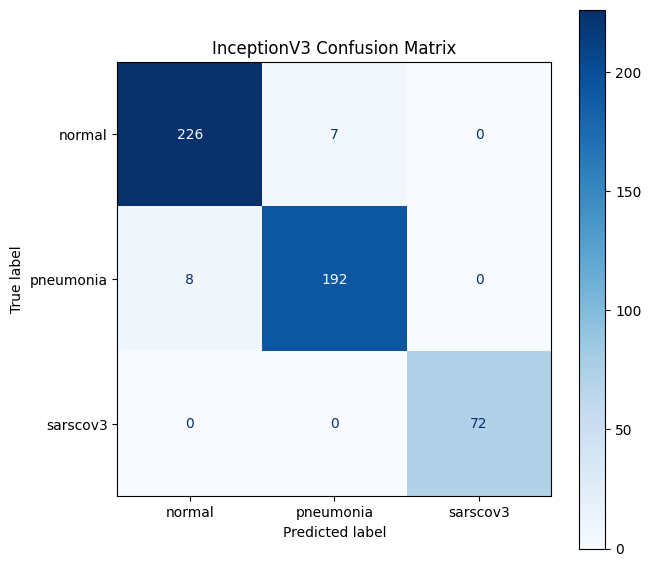

In [ ]:
# Create the confusion matrix for the modified InceptionV3 model
inceptionV3Matrix = confusion_matrix(inceptionV3Labels, inceptionV3Predictions)

# Show the confusion matrix for InceptionV3 as a heatmap
def showConfusionMatrix(confusionMatrix, classes, plotTitle='Confusion Matrix', cmap=cm.Blues):
    ''' Provides a visualization of the given confusion matrix.
    '''
    print('Confusion matrix (without normalization):')
    display = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix, display_labels=classes)
    fig, ax = subplots(figsize=(7, 7))
    display.plot(include_values=True, ax=ax, cmap=cmap)
    title(plotTitle)
    show()

classes = ['normal', 'pneumonia', 'sarscov3']
showConfusionMatrix(inceptionV3Matrix, classes, plotTitle='InceptionV3 Confusion Matrix')

Confusion matrix (without normalization):


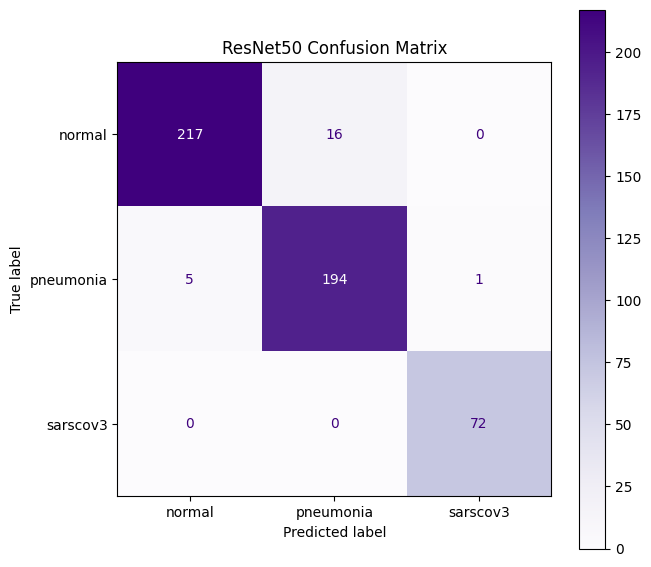

In [ ]:
# Create the confusion matrix for the modified ResNet50 model
resNet50Matrix = confusion_matrix(resNet50Labels, resNet50Predictions)

# Show the confusion matrix for ResNet50 as a heatmap
showConfusionMatrix(resNet50Matrix, classes, plotTitle='ResNet50 Confusion Matrix', cmap=cm.Purples)

📝 $Accuracy = \frac{\sum TP}{\sum N}$

InceptionV3: $\frac{226 + 192 + 72}{505} = \boxed{0.9703}$

ResNet50: $\frac{217 + 194 + 72}{505} = \boxed{0.9564}$

**Step 3:** Plot the precision-recall curves for the models. There are three classes, so the labels must be converted to binary classification.

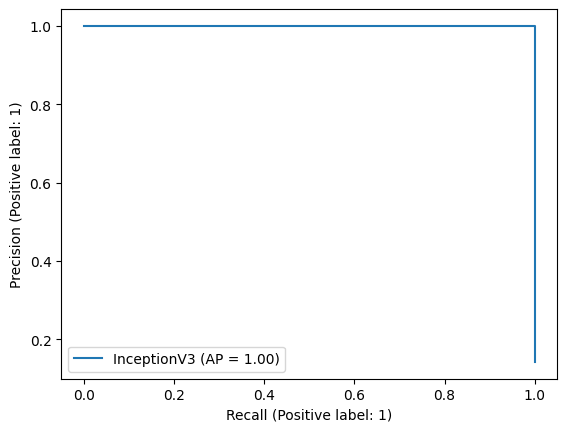

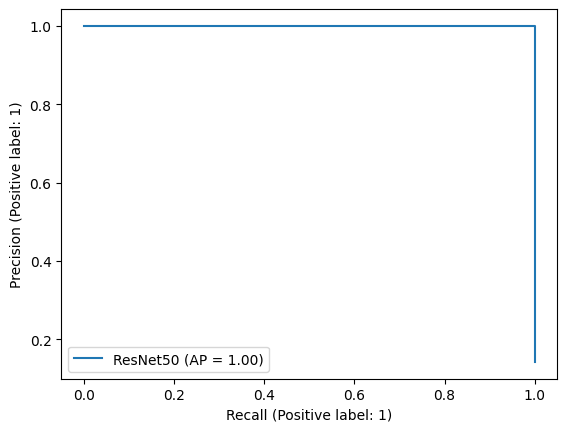

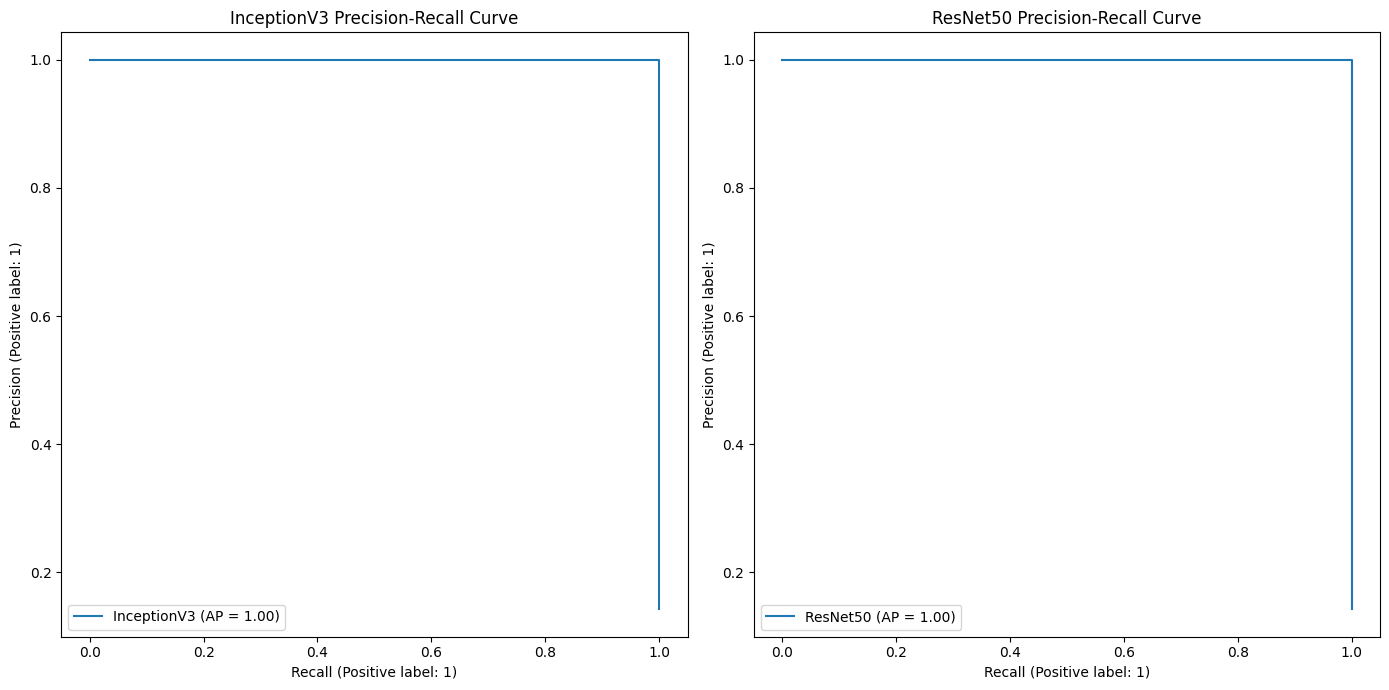

In [ ]:
# Convert labels to binary classification (SARS-CoV-3 vs. not-SARS-CoV-3)
inceptionV3BinaryLabels = [1 if label == 2 else 0 for label in inceptionV3Labels]
resNet50BinaryLabels = [1 if label == 2 else 0 for label in resNet50Labels]

# Compute the precision-recall curve and create a PrecisionRecallDisplay object for each model
inceptionV3Display = PrecisionRecallDisplay.from_predictions(inceptionV3BinaryLabels, inceptionV3Probabilities, name='InceptionV3')
resNet50Display = PrecisionRecallDisplay.from_predictions(resNet50BinaryLabels, resNet50Probabilities, name='ResNet50')

# Plot the precision-recall curves for InceptionV3 and ResNet50
fig, axs = subplots(nrows=1, ncols=2, figsize=(14, 7))
inceptionV3Display.plot(ax=axs[0])
axs[0].set_title('InceptionV3 Precision-Recall Curve')
resNet50Display.plot(ax=axs[1])
axs[1].set_title('ResNet50 Precision-Recall Curve')
tight_layout()
show()

📝 Both models achieve comparable performance, with InceptionV3 being slightly more accurate and precise than ResNet50. This could be attributed to architectural differences and differences in the numbers of parameters. ResNet50 is a larger model, so it is possible that it takes longer to train to achieve similar accuracy to InceptionV3. Therefore, InceptionV3 is selected as the best model.

## Computing Model Size
Using the `torchstat` library and assuming the trainable model parameters are 16-bit floats, the space required to store the InceptionV3 model is computed as follows:

In [ ]:
from torchstat import stat

stat(inceptionV3Model.to('cpu'), (3, 200, 200)) # Images are 200x200
numParams = sum(param.numel() for param in inceptionV3Model.parameters() if param.requires_grad) # Gets the number of trainable parameters
modelSizeInBytes = numParams * 2 # Two bytes for 16-bit floats
print(f'Model size (bytes): {modelSizeInBytes}')

[MAdd]: AdaptiveAvgPool2d is not supported!
[Flops]: AdaptiveAvgPool2d is not supported!
[Memory]: AdaptiveAvgPool2d is not supported!
[MAdd]: Flatten is not supported!
[Flops]: Flatten is not supported!
[Memory]: Flatten is not supported!
                         module name   input shape  output shape      params memory(MB)             MAdd            Flops  MemRead(B)  MemWrite(B) duration[%]    MemR+W(B)
0                 Conv2d_1a_3x3.conv     3 200 200    32  99  99       864.0       1.20     16,622,496.0      8,468,064.0    483456.0    1254528.0       0.66%    1737984.0
1                   Conv2d_1a_3x3.bn    32  99  99    32  99  99        64.0       1.20      1,254,528.0        627,264.0   1254784.0    1254528.0       0.19%    2509312.0
2                 Conv2d_2a_3x3.conv    32  99  99    32  97  97      9216.0       1.15    173,125,600.0     86,713,344.0   1291392.0    1204352.0       2.63%    2495744.0
3                   Conv2d_2a_3x3.bn    32  97  97    32  97  97        

/usr/local/lib/python3.10/dist-packages/torchstat/reporter.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(total_df)


📝 $\boxed{\mathrm{InceptionV3 \ model \ size} = 43.6 \ \mathrm{MB}}$

This is the amount of space required to store an instance of the best model (InceptionV3).

## Reflections

### Further Improving InceptionV3 Performance
Techniques to explore to further improve InceptionV3 performance include:
- Further correcting class imbalance using one of the aforementioned techniques (e.g., synthetic oversampling, cost-sensitive learning).
- Additional data augmentation $-$ Increasing the size of the dataset by generating new images through transformations.
- Ensembling $-$ Combining the outputs of the InceptionV3 model and other optimized models to reduce bias and variance.
- Hyperparameter fine-tuning $-$ Adjusting learning rate (e.g., scheduling) and batch size to optimize the model's training process.
- Incorporating patient demographic and clinical data, such as age and gender, in addition to the chest X-ray images, which would provide additional information that could help improve the model's performance.

### Why CNNs instead of SVMs?

- **Differences in features:** CNNs are better suited for image processing due to the fact that they exploit two properties: 
  1. **Abstraction hierarchy:** As one moves deeper inside the network along convolution and pooling layers, the features being learned are increasingly more abstract (e.g., lines and edges at the beginning, complex shapes in the middle, and objects at the end). 
  2. **Locality of features:** Pixels that are close together are correlated and this underpins the inner workings of CNNs, which progressively expand the region they are looking at as the image input is processed in the network. In SVMs, the features can be arbitrarily reordered. 

  In summary, CNNs are feature extractors in and of themselves, while SVMs require either inputting pixel values as raw features or inputting handcrafted features which do not benefit from large datasets (i.e., not "data driven").

- **Differences in training data:** I trained models that were pretrained on the very large ImageNet dataset. My CNNs benefited from knowledge acquired from training on that dataset even though it is unrelated to this particular application domain. The InceptionV3 and ResNet50 models I loaded had already learned to extract features from images, although they may not be appropriate for X-ray processing$-$which was the purpose of fine-tuning. An SVM would not benefit from this.